In [ ]:
# https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
# https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff
# https://github.com/marcopeix/Deep_Learning_AI/blob/master/4.Convolutional%20Neural%20Networks/2.Deep%20Convolutional%20Models/Residual%20Networks.ipynb
# https://github.com/qubvel/classification_models/blob/a0f006e05485a34ccf871c421279864b0ccd220b/classification_models/models/resnet.py#L112

In [ ]:
# Mount drive to save stuff there for later
from google.colab import drive, files
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Upload kaggle api key
! pip install -q kaggle
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Fetch train and test data from kaggle
! kaggle competitions download -c dogs-vs-cats-redux-kernels-edition

! mkdir train
! unzip train.zip -d train > downloadlog.txt

! mkdir test
! unzip test.zip -d test >> downloadlog.txt

 99% 539M/544M [00:08<00:00, 56.0MB/s]
100% 544M/544M [00:08<00:00, 69.0MB/s]
  0% 0.00/111k [00:00<?, ?B/s]
100% 111k/111k [00:00<00:00, 101MB/s]
 98% 265M/271M [00:03<00:00, 53.7MB/s]
100% 271M/271M [00:03<00:00, 78.3MB/s]


In [ ]:
import glob
import os
import cv2
import math
import datetime
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shutil

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
from pylab import rcParams

In [ ]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
# Check dirs on VM
os.listdir()

['.config',
 'test',
 'drive',
 'test.zip',
 'train.zip',
 'kaggle.json',
 'downloadlog.txt',
 'sample_submission.csv',
 'train',
 'sample_data']

In [ ]:
# Import UDFs
os.chdir('drive/My Drive/collab')
from helper_functions import *

In [ ]:
# Settings
INITIAL_TRAIN_DIR = 'train/train/' 
COMP_DIR = 'test/test/' 

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'

np.random.seed(0)
tf.random.set_seed(0)

ROWS = 224
COLS = 224
CHANNELS = 3

MIN_LR = 0.00002
MAX_LR = 0.0002 
BATCHSIZE = 32
CLR_METHOD = "triangular"
GAMMA = 0.99995
EPOCHS = 64
STEP_SIZE = 4 

rotation_range = 15
zoom_range = 0.15
width_shift_range = 0.2
height_shift_range = 0.2
shear_range = 0.15
horizontal_flip = True
fill_mode = "nearest"

experiment_name = 'cycling_resnet'
model_version = str(11)

rcParams['figure.figsize'] = 30, 6

In [ ]:
os.chdir('../../..')
X_files = np.array([INITIAL_TRAIN_DIR+i for i in os.listdir(INITIAL_TRAIN_DIR)])

# Get train and testset
X_train_filenames, X_test_filenames = train_test_split(X_files, test_size=0.1, random_state=0)

# Split traindata again into train and validation
X_train_filenames, X_val_filenames = train_test_split(X_train_filenames, test_size=0.1, random_state=0)

In [ ]:
sort_test_images(COMP_DIR)
prepare_file_structure(X_train_filenames, X_val_filenames, X_test_filenames)
show_directory_structure(startpath='data')

data/
   test/
      cats/
      dogs/
   validation/
      cats/
      dogs/
   train/
      cats/
      dogs/


In [ ]:
# Show examples of filenames
os.listdir('data/train/dogs/')[:5]

['dog.4279.jpg', 'dog.3110.jpg', 'dog.6164.jpg', 'dog.630.jpg', 'dog.744.jpg']

In [ ]:
def identity_block(X, f, filters, stage, block):
    
    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

def convolutional_block(X, f, filters, stage, block, s=2):

    # Defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### 
    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape = (64, 64, 3), classes = 2):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

def ResNet18(input_shape = (64, 64, 3), classes = 2):
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)
    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')

    # AVGPOOL
    X = AveragePooling2D(pool_size=(2,2), padding='same')(X)

    # Output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet18')

    return model

In [ ]:
# def residual_block(x: Tensor, filters: int, three_layers: bool = False, kernel_size: int = 3) -> Tensor:

#     y = Conv2D(filters=filters, kernel_size=kernel_size, activation=tf.nn.relu, padding='same', strides=2)(x)
#     y = Conv2D(filters=filters, kernel_size=kernel_size, activation=tf.nn.relu, padding='same', strides=1)(y) 

#     if three_layers:
#       y = Conv2D(filters=filters, kernel_size=kernel_size, activation=tf.nn.relu, padding='same', strides=1)(y) 

#     # Downsample x to be same size
#     x = Conv2D(kernel_size=1, strides=2, filters=filters, padding="same")(x)
#     #x = tf.keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2))(x)

#     out = Add()([x, y])

#     return out


# def create_res_net(ROWS, COLS, CHANNELS):

#     inputs = Input(shape=(ROWS, COLS, CHANNELS))

#     t = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='same', strides=1)(inputs)
#     t = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation=tf.nn.relu, padding='same', strides=1)(t) 

#     t = residual_block(x=t, filters=64, three_layers=False, kernel_size=3)
#     t = residual_block(x=t, filters=128, three_layers=True, kernel_size=3)
#     #t = residual_block(x=t, filters=256, three_layers=True, kernel_size=3)

#     t = Flatten()(t)
#     t = Dense(256, activation=tf.nn.relu)(t)
#     t = Dense(256, activation=tf.nn.relu)(t)
#     outputs = Dense(2, activation='softmax')(t)

#     model = Model(inputs, outputs)

#     return model

In [ ]:
model = ResNet50(input_shape = (ROWS, COLS, CHANNELS))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
              loss='sparse_categorical_crossentropy',  # Sparse for integers, just categorical for one hot encoded
              metrics=['accuracy'])

model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [ ]:
# save best model checkpoint
save_model = tf.keras.callbacks.ModelCheckpoint('drive/My Drive/collab/' + experiment_name + '.h5', monitor='val_loss', verbose=1, save_best_only=True, 
                                                save_weights_only=False, mode='auto', save_freq='epoch')

# Early stopping callback
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1, mode='auto')

# Cyclical learning rate callback
clr = CyclicLR(base_lr=MIN_LR, max_lr=MAX_LR, step_size=STEP_SIZE * -(-len(X_train_filenames)//BATCHSIZE), mode=CLR_METHOD, gamma=GAMMA)

# Create tensorboard callback
log_dir = "drive/My Drive/collab/logs/fit/" + experiment_name
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create augmentation generator
train_aug = ImageDataGenerator(
		rescale=1./255,
    rotation_range=rotation_range,
		zoom_range=zoom_range,
		width_shift_range=width_shift_range,
		height_shift_range=height_shift_range,
		shear_range=shear_range,
		horizontal_flip=horizontal_flip,
		fill_mode=fill_mode
)

test_aug = ImageDataGenerator(rescale=1./255)

train_generator = train_aug.flow_from_directory(train_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary')
val_generator = test_aug.flow_from_directory(validation_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary')
test_generator = test_aug.flow_from_directory(test_data_dir, target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary', shuffle=False)
comp_generator = test_aug.flow_from_directory('test', target_size=(ROWS, COLS), batch_size=BATCHSIZE, class_mode='binary', shuffle=False)

Found 20250 images belonging to 2 classes.
Found 2250 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


In [ ]:
# Train model
start = datetime.datetime.now()
print(start)

history = model.fit(train_generator,
                    batch_size=BATCHSIZE,
                    epochs=EPOCHS, 
                    validation_data=val_generator,
                    verbose=1,
                    callbacks=[clr, early, save_model, tensorboard_callback]
                ) 

print('Finished in: {}'.format(datetime.datetime.now() - start))
print(datetime.datetime.now())

2020-10-31 20:27:19.568968
Epoch 1/64
633/633 [==============================] - ETA: 0s - loss: 0.9984 - accuracy: 0.5593
Epoch 00001: val_loss improved from inf to 0.82219, saving model to drive/My Drive/collab/vgg16_cycling_resnet.h5
633/633 [==============================] - 301s 476ms/step - loss: 0.9984 - accuracy: 0.5593 - val_loss: 0.8222 - val_accuracy: 0.6173
Epoch 2/64
633/633 [==============================] - ETA: 0s - loss: 1.0084 - accuracy: 0.5917
Epoch 00002: val_loss did not improve from 0.82219
633/633 [==============================] - 294s 465ms/step - loss: 1.0084 - accuracy: 0.5917 - val_loss: 1.8958 - val_accuracy: 0.5796
Epoch 3/64
633/633 [==============================] - ETA: 0s - loss: 0.9342 - accuracy: 0.6106
Epoch 00003: val_loss did not improve from 0.82219
633/633 [==============================] - 294s 464ms/step - loss: 0.9342 - accuracy: 0.6106 - val_loss: 4.9720 - val_accuracy: 0.5627
Epoch 4/64
633/633 [==============================] - ETA: 0s - 

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

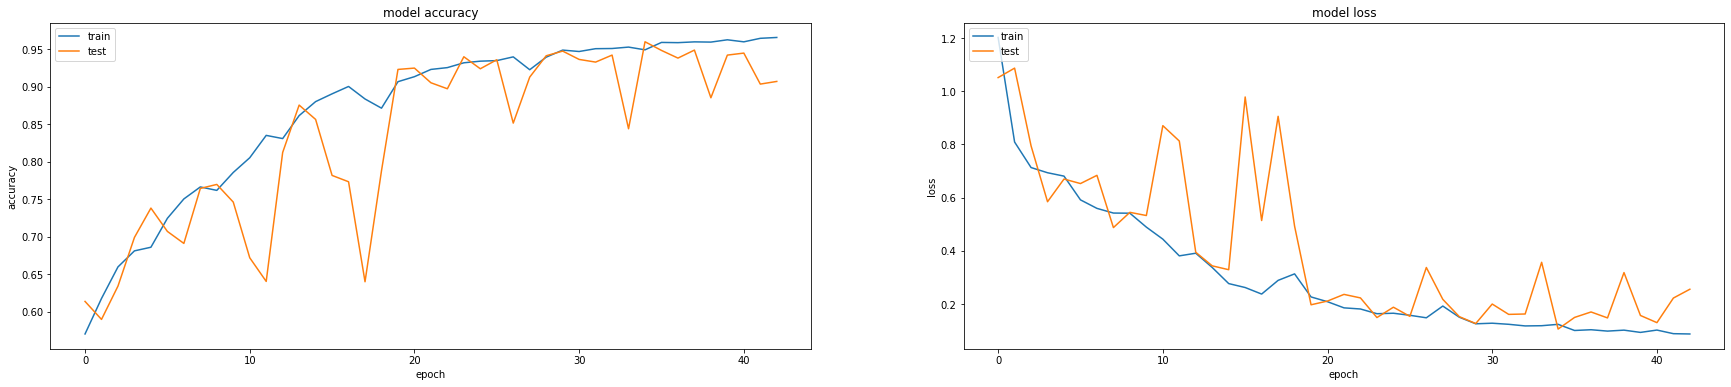

In [ ]:
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
training_history_plots(history, clr)

In [ ]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)

79/79 [==============================] - 9s 111ms/step - loss: 0.2544 - accuracy: 0.8952


In [ ]:
# read in best version of model here
saved_model = tf.keras.models.load_model('drive/My Drive/collab/vgg16_' + experiment_name + '.h5')

In [ ]:
test_loss, test_acc = saved_model.evaluate(test_generator, verbose=1)

79/79 [==============================] - 9s 120ms/step - loss: 0.0829 - accuracy: 0.4816


In [ ]:
preds = []
actuals = []
for i in range(78):
    X, y = test_generator.next()
    prediction = saved_model.predict(X)
    preds.append(list(np.round(prediction[:, 1])))
    actuals.append(list(y))

actuals = [item for sublist in actuals for item in sublist]
preds = [item for sublist in preds for item in sublist]
print('Accuracy score: {}'.format(accuracy_score(actuals, preds)))
confusion_matrix(actuals, preds)

Accuracy score: 0.96875


array([[1163,   37],
       [  41, 1255]])

100%|██████████| 9/9 [00:00<00:00, 188.17it/s]


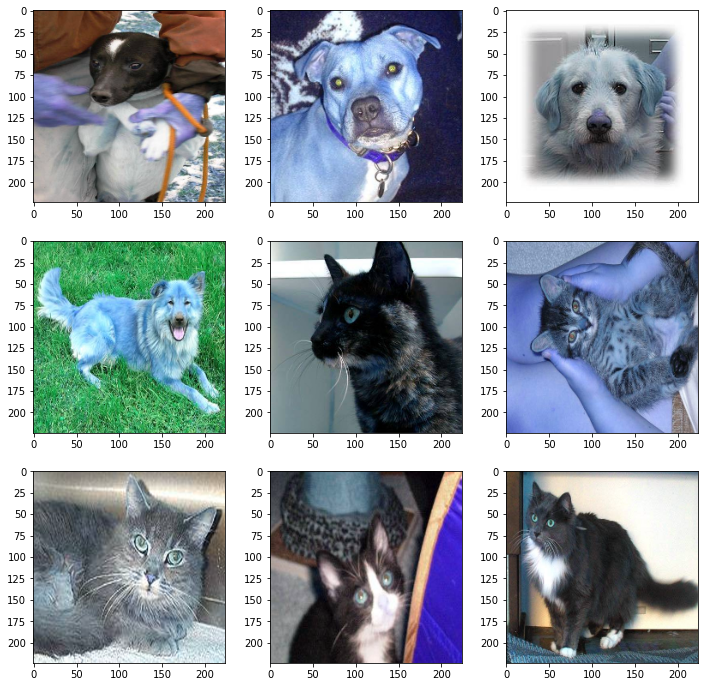

In [ ]:
# Load some images to see if everything went right
test_images = [COMP_DIR + x for x in os.listdir(COMP_DIR)]
test_images.sort()
comp_data = prep_data(test_images[:9], ROWS, COLS, CHANNELS)

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    ax.imshow(comp_data[i])

In [ ]:
predictions_comp_data = pd.DataFrame({'id': range(1, len(os.listdir(COMP_DIR)) + 1), 'label': np.clip(saved_model.predict(comp_generator)[:, 1], 0.02, 0.98)})
predictions_comp_data['label'] = round(predictions_comp_data['label'], 4)
predictions_comp_data.head(9)

,id,label
0,1,0.98
1,2,0.98
2,3,0.98
3,4,0.98
4,5,0.02
5,6,0.02
6,7,0.02
7,8,0.02
8,9,0.02


In [ ]:
submission_path = 'drive/My Drive/collab/submission_simple_resnet50' + '.csv'
predictions_comp_data.to_csv(submission_path, index=False)

In [ ]:
! kaggle competitions submit -c dogs-vs-cats-redux-kernels-edition -f 'drive/My Drive/collab/submission_simple_resnet50.csv' -m "resnet50, clip 0.02"

100% 127k/127k [00:04<00:00, 26.3kB/s]
Successfully submitted to Dogs vs. Cats Redux: Kernels Edition